In [105]:
import glob
import json
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Run all notebooks

In [106]:
!jupyter nbconvert --to notebook --execute --inplace --ExecutePreprocessor.timeout=-1 1-generate-triangles.ipynb
!jupyter nbconvert --to notebook --execute --inplace --ExecutePreprocessor.timeout=-1 2-numba.ipynb
!jupyter nbconvert --to notebook --execute --inplace --ExecutePreprocessor.timeout=-1 3-julia.ipynb
!jupyter nbconvert --to notebook --execute --inplace --ExecutePreprocessor.timeout=-1 4-fortran-via-python-ctypes.ipynb
!jupyter nbconvert --to notebook --execute --inplace --ExecutePreprocessor.timeout=-1 5-fortran-via-julia-ccall.ipynb
!jupyter nbconvert --to notebook --execute --inplace --ExecutePreprocessor.timeout=-1 6-cpp-via-cython.ipynb
!jupyter nbconvert --to notebook --execute --inplace --ExecutePreprocessor.timeout=-1 7-shapely.ipynb
!jupyter nbconvert --to notebook --execute --inplace --ExecutePreprocessor.timeout=-1 8-pygeos.ipynb

# Check answers

In [107]:
reference = np.load("./answers/shapely.npy")
answer_paths = glob.glob("./answers/*.npy")
for p in answer_paths:
    a = np.load(p)
    if not np.allclose(a, reference):
        print(f"{p} has the wrong answers")

# Load and plot timing data

In [108]:
json_paths = glob.glob("./timing/*.json")
timings = {}
for p in json_paths:
    path = pathlib.Path(p)
    d = json.load(open(p))
    # Sort by number
    timings[path.stem] = {k: v for k, v in sorted(d.items(), key=lambda item: int(item[0]))}

# Sort entries by 100_000 value
timings = {k: v for k, v in sorted(timings.items(), key=lambda item: item[1]["100000"], reverse=True)}

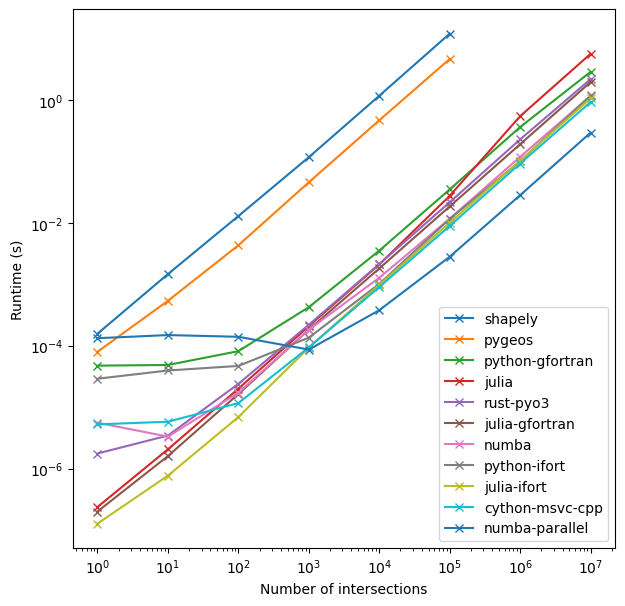

In [109]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel("Runtime (s)")
ax.set_xlabel("Number of intersections")

for key, value in timings.items():
    x = list(map(float, list(value.keys())))
    y = list(value.values())
    ax.plot(x, y, label=key, marker='x')
    
ax.legend()
fig.savefig("runtime.svg", dpi=300)

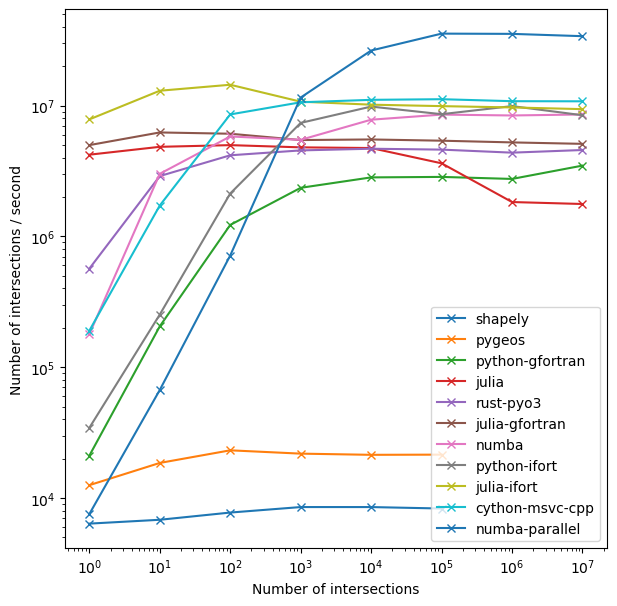

In [110]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel("Number of intersections / second")
ax.set_xlabel("Number of intersections")

for key, value in timings.items():
    x = list(map(float, list(value.keys())))
    y = list(value.values())
    y = [a / b for a, b in zip(x, y)]
    ax.plot(x, y, label=key, marker='x')

ax.legend()
fig.savefig("per_second.svg", dpi=300)

In [111]:
selection = {k: v["100000"] for k, v in timings.items()}
df = pd.DataFrame.from_dict(
    {
        "Method": list(selection.keys()),
         "Relative runtime": list(selection.values())
    }
).set_index("Method")
df["Relative runtime"] /= df["Relative runtime"].iloc[-2]
print(df.to_markdown())

| Method          |   Relative runtime |
|:----------------|-------------------:|
| shapely         |         1346.92    |
| pygeos          |          521.667   |
| python-gfortran |            3.92701 |
| julia           |            3.09113 |
| rust-pyo3       |            2.42885 |
| julia-gfortran  |            2.07592 |
| numba           |            1.31112 |
| python-ifort    |            1.30204 |
| julia-ifort     |            1.12967 |
| cython-msvc-cpp |            1       |
| numba-parallel  |            0.3152  |


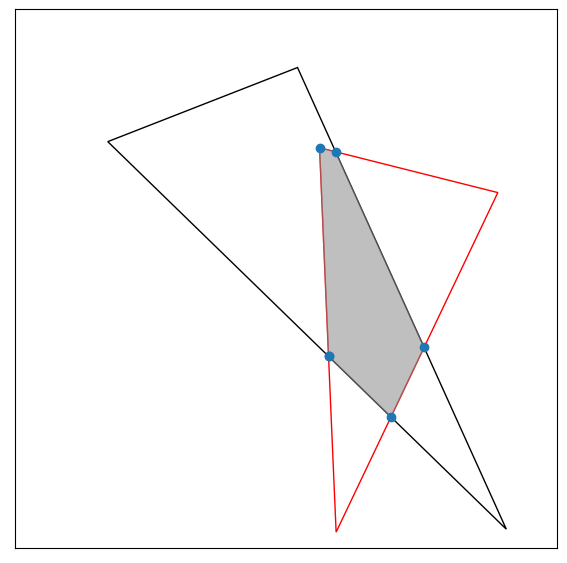

In [112]:
import shapely.geometry as sg

a = np.array(
   [[0.52102399, 0.89166603],
    [0.17127911, 0.75417214],
    [0.90588225, 0.03515472]]
)
b = np.array(
   [[0.56164461, 0.74282246],
    [0.89026977, 0.65965251],
    [0.59218689, 0.02969307]]
)

p1 = sg.Polygon(a)
p2 = sg.Polygon(b)
intersection = np.array(p1.intersection(p2).exterior.coords)

fig, ax = plt.subplots(figsize=(7, 7))
ax.add_artist(plt.Polygon(a, fill=False, color="k"))
ax.add_artist(plt.Polygon(b, fill=False, color="r"))
ax.add_artist(plt.Polygon(intersection, color="gray", alpha=0.5))
ax.scatter(x=intersection[:, 0], y=intersection[:, 1])
ax.set_xlim((0.0, 1.0))
ax.set_ylim((0.0, 1.0))
ax.set_xticks([])
ax.set_yticks([])
fig.savefig("intersection.svg")